In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_recommenders as tfrs

import os
from os import path, getcwd, listdir, chdir
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# from google.colab import drive 
# drive.mount('/content/drive')
# chdir('/content/drive/My Drive/Colab Notebooks/Data_Imputation/')

SEED = 121

In [2]:
data = pd.read_csv('./data/train_set_v3.txt', sep='\t')

In [3]:
# submission = pd.read_csv('./data/test_set_without_yield_v3.txt', sep='\t')
# submission.shape

In [4]:
# data.groupby([])

In [5]:

data.head(1)

,Hybrid,Experiment code,Year,Location,Yield,Inbred 1,Inbred 2,Inbred 1 genetic group,Inbred 2 genetic group,trial_cluster_level1,trial_cluster_level2
0,hybrid_0,trial_0,2014,loc_0,240.28,parent_0,parent_2215,genetic_group_0,genetic_group_33,03,03b


In [6]:
data = data.drop(columns=['Hybrid'])
data.fillna('UNK', inplace=True) 
data = data.sample(len(data), replace=False, random_state=SEED)
train, test = train_test_split(data, test_size=0.036, random_state=SEED)
val, test = train_test_split(test, test_size=0.45, random_state=SEED)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

# create scaler
# scaler = MinMaxScaler()
# # fit scaler on data
# scaler.fit(np.reshape(train['Yield'].values, (-1, 1)))
# # Fit new values
# train['Yield'] = scaler.transform(np.reshape(train['Yield'].values, (-1, 1))).squeeze()
# val['Yield'] = scaler.transform(np.reshape(val['Yield'].values, (-1, 1))).squeeze()
# test['Yield'] = scaler.transform(np.reshape(test['Yield'].values, (-1, 1))).squeeze()


523367 train examples
10749 validation examples
8796 test examples


In [7]:
def data_preparation(train, test):
    results = dict()
    test = test.copy()
    
    cols = train.columns
    loc_grp = train.groupby(['Location'])['Yield'].agg(
        yield_mean='mean', std_yied='std').reset_index()
    results['operations'] = {}
    results['operations'][0] = loc_grp
    train_loc = pd.merge(train, loc_grp, on='Location')
    train_loc['Yield'] = (train_loc['Yield'] - train_loc['yield_mean']) #/(train_loc['std_yied'])
    train_loc = train_loc[cols]
    # test
    test = pd.merge(test, loc_grp, on='Location')
    test['Yield'] = (test['Yield'] - test['yield_mean']) #/ test['std_yied']
    test = test[cols]
    
    # second operation
    cluster1_grp = train_loc.groupby(['trial_cluster_level1'])['Yield'].agg(yield_mean='mean', std_yied='std').reset_index()
    train_cluster = pd.merge(train_loc, cluster1_grp, on='trial_cluster_level1')
    train_cluster['Yield'] = (train_cluster['Yield'] - train_cluster['yield_mean']) #/ (train_cluster['std_yied'])
    results['operations'][1] = cluster1_grp
    train_cluster = train_cluster[cols]
    # test
    test = pd.merge(test, cluster1_grp, on='trial_cluster_level1')
    test['Yield'] = (test['Yield'] - test['yield_mean']) #/ test['std_yied']
    test = test[cols]
    
    results['train'] = train_cluster
    results['test'] = test
    return results

In [8]:
# results = data_preparation(train_, val_)
# train = results['train']
# val = results['test']

In [9]:
# val.head()

In [10]:
# labels = dataframe.pop('Yield')

# A utility method to create a tf.data dataset from a Pandas Dataframe

def df_to_dataset(dataframe, shuffle=True, batch_size=32, labels=None, feature_cols=None):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Yield')
#   features_cols = ['hybrid', 'trial', 'year', 'location', 'inbred1', 'inbred2', 'genetic_inb1', 'genetic_inb2', 'trial_cl1', 'trial_cl2']
  dataframe.columns = features_cols #['hybrid', 'trial', 'year', 'location', 'inbred1', 'inbred2', 'genetic_inb1', 'genetic_inb2', 'trial_cl1', 'trial_cl2']
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds


In [11]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer


In [12]:
def get_category_encoding_layer(name, dataset, dtype, vocab=None, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  vocab = np.unique(np.concatenate(list(dataset.map(lambda x, _: x[name]))))
  if dtype == 'string':
    index = preprocessing.StringLookup(vocabulary=vocab)
  else:
    index = preprocessing.IntegerLookup(vocabulary=vocab)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
  feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))


In [13]:
features_cols = ['trial', 'year', 'location', 
                 'inbred1', 'inbred2', 
                 'genetic_inb1', 
                 'genetic_inb2', 'trial_cl1', 'trial_cl2']


In [14]:
batch_size = 16
train_ds = df_to_dataset(train, batch_size=batch_size, feature_cols=features_cols)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size, feature_cols=features_cols)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size, feature_cols=features_cols)


In [15]:
all_inputs = []
encoded_features = {}

# Numeric features.
for header in []: # nothing here for now
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features[header] = encoded_numeric_col


In [16]:
def get_numeric_normalization_encoding(header, train_ds):
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    return numeric_col, encoded_numeric_col

In [17]:
# Categorical features encoded as integers.
categorical_nums = ['year']
for header in categorical_nums:
  year_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64')
  encoded_year_col = encoding_layer(year_col)
  all_inputs.append(year_col)
  encoded_features[header] = encoded_year_col


In [18]:
def get_num_categorical_encoding(header, train_ds):
    int_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64')
    encoded_int_col = encoding_layer(int_col)
    return int_col, encoded_int_col

In [19]:
# Categorical features encoded as string.
# categorical_cols = [name  for name in train.columns if train[name].dtype not in ['int64', 'float64', 'float32']]
categorical_cols = ['trial','location', 
                    'inbred1', 'inbred2', 
                    'genetic_inb1', 'genetic_inb2', 'trial_cl1', 'trial_cl2']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features[header] = encoded_categorical_col


In [20]:
def get_categorical_encoding(header, train_ds):
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
    encoded_categorical_col = encoding_layer(categorical_col)
    return categorical_col, encoded_categorical_col


In [21]:
def get_encoding_col(header, train_ds, dtype=None):
    if dtype is None:
        for train, y in train_ds.as_numpy_iterator():
            dtype = train[header].dtype
            break
#         break
    dtypes = {
        object: 'string',
        float: float,
        'int64': 'int64'
    }
    pass

In [22]:
data_features = data[[ 'Experiment code', 'Year', 'Location', 
                      'Inbred 1', 'Inbred 2', 
                      'Inbred 1 genetic group ', 'Inbred 2 genetic group',
                      'trial_cluster_level1', 'trial_cluster_level2']]
data_features.columns = features_cols

embeddings_voc_length_dict = {
    col: len(data_features[col].unique()) + 1 for col in data_features.columns
}

In [23]:
embedding_dim = 20

embeddings = {
    name + '_embedding': keras.layers.Embedding(
        name=name+'_emb',
        input_dim=length,
        output_dim=embedding_dim)(encoded_features[name])
    for name, length in embeddings_voc_length_dict.items()
}

wide_embeddings = {
    name + '_embedding': keras.layers.Embedding(
        name=name+'_emb',
        input_dim=length,
        output_dim=embedding_dim)(encoded_features[name])
    for name, length in embeddings_voc_length_dict.items() if name.startswith('inbred')
}

In [24]:
def build_embeddings(embedding_dim, encoded_features):
    embeddings = {
        name + '_embedding': keras.layers.Embedding(
            name=name+'_emb',
            input_dim=length,
        output_dim=embedding_dim)(encoded_features[name])
        for name, length in embeddings_voc_length_dict.items()
    }
    return embeddings

In [25]:
import gc
gc.collect()

535

In [26]:
def build_and_compile(
        optimizer, 
        loss,
        num_cross_layers=1,
        deep_layers=None,
        embedding_dim=None, 
        projection_dim=None,
        encoded_features=None,
        embeddings_voc_length_dict=None,
        **kwargs
    ):
    """
    """
    # get all inputs
    
    all_inputs = get_all_inputs()
    
    embeddings = build_embeddings(embedding_dim, encoded_features)
    
    dcn = DCNModel(None)
    x = dcn(all_inputs)
    model = keras.Model(all_inputs, x)
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [27]:
class DCNModel(tfrs.Model):
    def __init__(self, embeddings, all_inputs, num_cross_layers, deep_layers, projection_dim=None, **kwargs):
        self._data_checker(embeddings, num_cross_layers, deep_layers)
        super(DCNModel, self).__init__(**kwargs)
        self.projection_dim = projection_dim
        self.embeddings = embeddings
#         self.all_inputs = all_inputs
        self.num_cross_layers = num_cross_layers
        self.deep_layers = deep_layers
        
#         self.combined_embeddings = tf.keras.layers.concatenate(list(self.embeddings.values()), axis=1)
        self._crosses = [tfrs.layers.dcn.Cross(projection_dim=self.projection_dim, name=f'cross_{i}') 
                        for i in range(self.num_cross_layers)]
        self._flatten = tf.keras.layers.Flatten()
        self._denses = [tf.keras.layers.Dense(units, activation='relu', name=f'dense_{i}') 
                       for i,units in enumerate(self.deep_layers)] 
        self._batch_norm = tf.keras.layers.BatchNormalization()
        self._output = tf.keras.layers.Dense(1)
    
    def _data_checker(self, embeddings, all_inputs, num_cross_layers, deep_layers):
        assert isinstance(embeddings, dict), f'{embeddings} should be a "dict" but you provided a {type(embeddings)}'
        assert isinstance(num_cross_layers, int) or isinstance(num_cross_layers, float), f'{num_cross_layers} should be int or float'
        assert isinstance(deep_layers, list), f'{deep_layers} should be a "list" but you provided a {type(deep_layers)}'
#         assert isinstance(all_inputs, list), f'{all_inputs} should be a list of tensors'
        
    def call(self, all_inputs):
        combined_embeddings = tf.keras.layers.concatenate(list(self.embeddings.values()), axis=1)(all_inputs)
        for i, cross in enumerate(self._crosses):
            if i == 0:
                y = cross(combined_embeddings)
            else:
                y = cross(combined_embeddings, y)
        # add more layers later
        x = self._flatten(y)
        for cnter, layer in enumerate(self._denses):
            x = layer(x)
            if cnter == 0:
                x = self._batch_norm(x)
        x = self._output(x)
#         model = tf.keras.models.Model(inputs=all_inputs, outputs=x)
        return x

In [ ]:
class IRNetBlock(tf.keras.Model):
    def __init__(self, num_reurons, activation='relu', **kwargs):
        super(IRNetBlock, self).__init__(**kwargs)
        self.num_neurons = num_neurons
        self._dense = tf.keras.layers.Dense(self.num_neurons)
        self._act = tf.keras.layers.Activation(activation)
        self._bn = tf.keras.layers.BatchNormalization()
        self._add = tf.keras.layers.Add()
    
    def call(self, inputs):
        x = self._dense(inputs)
        x = self._bn(x)
        x = self._add([inputs, x])
        x = self._act(x)
        return x
    
class SRNetBlock(tf.keras.Model):
    ''' Creates a layer'''
    def __init__(self, num_rerons, **kwargs):
        super(SRNetBlock, self).__init__(**kwargs)
        self.num_neurons = num_neurons
        self._dense = [tf.keras.layers.Dense(n) for n in self.num_neurons]
        self._act = tf.keras.layers.Activation(activation)
        self._bn = [tf.keras.layers.BatchNormalization() for _ in self.num_neurons]
        self._add = tf.keras.layers.Add()
    
    def call(self, inputs):
        x = None
        
        for i, (dense, bn) in enumerate(zip(self._dense, self._bn)):
            if i == 0:
                x = dense(inputs)
            else:
                x = dense(x)
            x = bn(x)
            # add the activation only for layers before the last one
            if i < len(self.num_neurons) - 1:
                x = self._act(x)
        x = self._add([inputs, x])
        x = self._act(x)
        return x
            

In [28]:
gene_env_year = tf.keras.layers.concatenate(list(embeddings.values()), axis=1)
wide_layer = tf.keras.layers.concatenate(list(wide_embeddings.values()), axis=1)

y = tfrs.layers.dcn.Cross(projection_dim=embedding_dim//2)(gene_env_year)
# y = tfrs.layers.dcn.Cross(projection_dim=embedding_dim//2)(y, gene_env_year)
# y = tfrs.layers.dcn.Cross(projection_dim=embedding_dim//2)(gene_env_year, y)

x = keras.layers.Flatten()(y)
x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.1)(x)

# xy = tf.keras.layers.Concatenate()([x, y])
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)

In [29]:
class CustomLoss(tf.keras.losses.Loss):
    """ Quantile loss """
#     learning_rate = .001
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
#         self.learning_rate = learning_rate
    def call(self, pred, actual):
        error = K.abs(pred - actual)
        cond100 = error >= 5
        cond50 = tf.math.logical_and(2.5 <= error, error < 5)
        cond0 = error < 2.5
        loss_100 = 100 * tf.square(error)
        loss_50 = 50 * tf.square(error)
        loss_0 = tf.square(error)

        func_error = tf.where(cond100, loss_100, tf.where(cond50, loss_50, loss_0))
        return K.mean(func_error, axis=-1)

In [30]:
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.0e-2, decay=1e-5),
              loss=CustomLoss(name='cmse'),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])


In [31]:
# rankdir='LR' is used to make the graph horizontal.
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trial (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
year (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
location (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
inbred1 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [32]:
gc.collect()

722

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse', 
    verbose=.01,
    patience=5,
    mode='min',
    min_delta=.1,
    restore_best_weights=True)


In [34]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/5
32711/32711 [==============================] - 5855s 179ms/step - loss: 78797.1085 - rmse: 26.7600 - mae: 19.9111 - val_loss: 38862.2461 - val_rmse: 19.7407 - val_mae: 14.8861
Epoch 2/5
32711/32711 [==============================] - 5790s 177ms/step - loss: 36664.2141 - rmse: 19.1749 - mae: 14.6420 - val_loss: 36103.3516 - val_rmse: 19.0304 - val_mae: 14.4053
Epoch 3/5
32711/32711 [==============================] - 5844s 179ms/step - loss: 77175.1801 - rmse: 27.2351 - mae: 15.0794 - val_loss: 36517.3398 - val_rmse: 19.1391 - val_mae: 14.4007
Epoch 4/5
32711/32711 [==============================] - 5874s 179ms/step - loss: 31387.3939 - rmse: 17.7490 - mae: 13.4522 - val_loss: 39444.4688 - val_rmse: 19.8867 - val_mae: 15.0160
Epoch 5/5
32711/32711 [==============================] - 6385s 195ms/step - loss: 30399.3016 - rmse: 17.4695 - mae: 13.1723 - val_loss: 38552.1719 - val_rmse: 19.6621 - val_mae: 14.8413


In [35]:
# history2 = model.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=[early_stopping])

In [42]:
preds = model.predict(test_ds)

In [43]:
preds = preds_norm.squeeze()

In [38]:
# def reconstruct(results, test, preds):
#     test_df = test.copy() # make a copy of the data to conserve the original data
#     if 'Yield' in test_df.columns:
#         test_df.drop(columns=['Yield'], inplace=True)
#     test_df['yield'] = preds
#     # make a copy of the columns to be reused
#     cols = test_df.columns
#     operations = results['operations']
#     n_operations = len(operations)
#     for op in range(n_operations - 1, -1, -1):
#         test_df = pd.merge(test_df, operations[op], on=operations[op].columns[0])
#         test_df['yield'] = test_df['yield_mean'] + test_df['yield'] #* test_df['std_yied']
#         test_df = test_df[cols]
#     return test_df

(array([  13.,   22.,   72.,  281., 1048., 2211., 2746., 1883.,  465.,
          55.]),
 array([ 65.35502 ,  88.9586  , 112.562195, 136.16579 , 159.76938 ,
        183.37296 , 206.97655 , 230.58014 , 254.18372 , 277.78732 ,
        301.3909  ], dtype=float32),
 <a list of 10 Patch objects>)

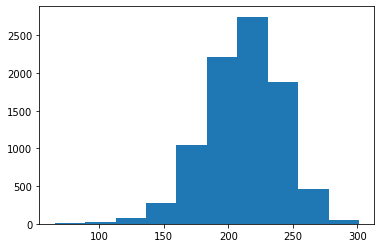

In [39]:
# plt.hist(preds_norm)

In [40]:
# preds_test_df = reconstruct(results, test, preds_norm)
# preds = preds_test_df['yield']

NameError: name 'results' is not defined

(array([  13.,   22.,   72.,  281., 1048., 2211., 2746., 1883.,  465.,
          55.]),
 array([ 65.35502 ,  88.9586  , 112.562195, 136.16579 , 159.76938 ,
        183.37296 , 206.97655 , 230.58014 , 254.18372 , 277.78732 ,
        301.3909  ], dtype=float32),
 <a list of 10 Patch objects>)

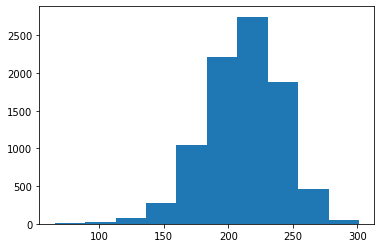

In [44]:
plt.hist(preds)

In [ ]:
plt.hist(test['Yield'])

Text(0, 0.5, 'Actual')

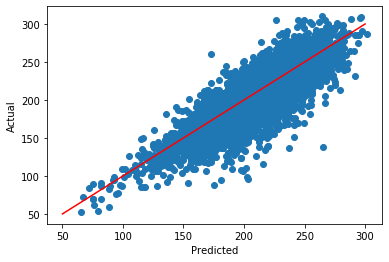

In [45]:
plt.scatter(preds, test['Yield'])
plt.plot([50, 300], [50, 300], 'r-')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [46]:
model.evaluate(test_ds)

550/550 [==============================] - 33s 59ms/step - loss: 37458.6328 - rmse: 19.3811 - mae: 14.8015


[37458.6328125, 19.381088256835938, 14.801543235778809]

In [47]:
from sklearn.metrics import r2_score
r2_score(preds, test['Yield'])

0.569206451108009

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')

In [ ]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.legend(['train RMSE', 'val RMSE'])
plt.xlabel('Epochs')

In [ ]:
res = test['Yield'] - preds

In [ ]:
plt.hist(res)

In [ ]:
# model.save('./savedModels/model_18_8')

In [ ]:
# tr_ds2 = df_to_dataset(train, batch_size=batch_size, feature_cols=features_cols, shuffle=False)
# tr_preds = model.predict(tr_ds2)
# tr_preds = tr_preds.squeeze()

# plt.scatter(train['Yield'], tr_preds)
# plt.plot([10, 300], [10, 300], 'r-')
# plt.xlabel('actual')
# plt.ylabel('predicted')

In [ ]:
# np.min(train['Yield'])

In [ ]:
# cross_layers[0]._dense.kernel

In [ ]:
# cross_layers[0]._

In [ ]:
# model.layers[28].embeddings

In [ ]:
data['Year'].unique()

In [ ]:
encoded_features['year'] #['2016']

In [ ]:
train.columns

In [ ]:
plt.hist(data.groupby(['Location'])['Yield'].mean())

In [ ]:
plt.plot(data.groupby(['trial_cluster_level1'])['Yield'].mean())

In [ ]:
loc_grp = train.groupby(['Location'])['Yield'].agg(yield_mean='mean', std_yied='std').reset_index().sort_values('yield_mean')

In [ ]:
train_loc = pd.merge(train, loc_grp, on='Location')
train_loc['Yield'] = (train_loc['Yield'] - train_loc['yield_mean']) /(train_loc['std_yied'])

In [ ]:
train_loc

In [ ]:
plt.plot(train_loc.groupby(['trial_cluster_level2'])['Yield'].mean())

In [ ]:
plt.hist(train_loc['Yield'])

In [ ]:
train_loc = train_loc[train.columns]
cluster1_grp = train_loc.groupby(['trial_cluster_level1'])['Yield'].agg(yield_mean='mean', std_yied='std').reset_index().sort_values('yield_mean')
train_cluster = pd.merge(train_loc, cluster1_grp, on='trial_cluster_level1')
train_cluster['Yield'] = (train_cluster['Yield'] - train_cluster['yield_mean']) / (train_cluster['std_yied'])

In [ ]:
plt.hist(train_cluster['Yield'])

In [ ]:
plt.plot(train_cluster.groupby(['Year'])['Yield'].mean())

In [ ]:
train_cluster = train_cluster[train.columns]
year_grp = train_cluster.groupby(['Year'])['Yield'].agg(yield_mean='mean', std_yied='std').reset_index().sort_values('yield_mean')
train_year = pd.merge(train_cluster, year_grp, on='Year')
train_year['Yield'] = (train_year['Yield'] - train_year['yield_mean']) / (train_year['std_yied'])

In [ ]:
plt.hist(train_year['Yield'])

In [ ]:
plt.plot(train_year.groupby(['Year'])['Yield'].mean())

In [ ]:
np.mean(train_year['Yield'].sort_values())